# Fisheye Visual Odometry with Homography

This notebook streamlines the existing pose recovery workflow into three focused:

- Undistort fisheye frames to verify calibration quality
- Track and filter feature correspondences between rectified frames
- Integrate homography-derived motions into a relative trajectory and plot the path

In [111]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from pose_helpers import analyze_trajectory, plot_trajectory, write_video_with_trajectory, draw_tracks, TrajectoryResult, TrajectoryVideoWriter

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 11

In [112]:
# --- Configuration ---
PROJECT_ROOT = Path("./flight")
VIDEO_PATH = PROJECT_ROOT / "recording.mp4"
CALIBRATION_PATH = PROJECT_ROOT / "calibration-params.json"

if not VIDEO_PATH.exists():
    raise FileNotFoundError(VIDEO_PATH)
if not CALIBRATION_PATH.exists():
    raise FileNotFoundError(CALIBRATION_PATH)

print(f"Video: {VIDEO_PATH}")
print(f"Calibration: {CALIBRATION_PATH}")

Video: flight/recording.mp4
Calibration: flight/calibration-params.json


In [113]:
# --- Calibration & undistortion helpers ---
def load_camera_intrinsics(json_path: Path) -> Tuple[np.ndarray, np.ndarray, Tuple[int, int]]:
    """Return camera matrix K, distortion vector D, and image size."""
    with open(json_path, "r") as f:
        load = json.load(f)

    load = load["cameras"][0]
    d = np.array(load["distortionCoefficients"])
    cx, cy = load["principalPointX"], load["principalPointY"]
    fx, fy = load["focalLengthX"], load["focalLengthY"]
    height, width = load["imageHeight"], load["imageWidth"]
    K = np.array([[fx, 0, cx], ## s = 0 
                 [0, fy, cy],
                 [0, 0, 1]]) 
    return K, d, (width, height)

def create_fisheye_rectification_maps(
    K: np.ndarray,
    D: np.ndarray,
    image_size: Tuple[int, int],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Pre-compute undistortion maps for faster remapping during VO."""
    map1, map2 = cv.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv.CV_16SC2)
    return K, map1, map2 ## new K?

def undistort_with_maps(frame: np.ndarray, map1: np.ndarray, map2: np.ndarray) -> np.ndarray:
    """Apply pre-computed undistortion maps to a frame."""
    return cv.remap(frame, map1, map2, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)
    


def read_frame(video_path: Path, index: int) -> np.ndarray:
    cap = cv.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open {video_path}")
    cap.set(cv.CAP_PROP_POS_FRAMES, index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Failed to read frame {index}")
    return frame


def read_frame_pair(video_path: Path, base_index: int, offset: int) -> Tuple[np.ndarray, np.ndarray]:
    first = read_frame(video_path, base_index)
    second = read_frame(video_path, base_index + offset)
    return first, second

In [114]:
K, D, image_size = load_camera_intrinsics(CALIBRATION_PATH)
print("Camera intrinsics loaded")
print(f"Image size   : {image_size[0]} x {image_size[1]}")
print(f"Focal lengths: fx={K[0, 0]:.2f}, fy={K[1, 1]:.2f}")
print(f"Principal pt : cx={K[0, 2]:.2f}, cy={K[1, 2]:.2f}")
print(f"Distortion   : {D.ravel()}")

NEW_K, undistort_map1, undistort_map2 = create_fisheye_rectification_maps(K, D, image_size)
print("Rectification maps prepared.")

Camera intrinsics loaded
Image size   : 1920 x 1080
Focal lengths: fx=590.07, fy=589.52
Principal pt : cx=1015.07, cy=571.36
Distortion   : [-0.03678765  0.00404803 -0.00777366  0.00206872]
Rectification maps prepared.


## 1. Undistortion Check

Rectify a representative frame with the fisheye calibration to confirm that straight edges appear linear and the field of view remains sufficient.

Raw frame shape        : (1080, 1920, 3)
Undistorted frame shape: (1080, 1920, 3)


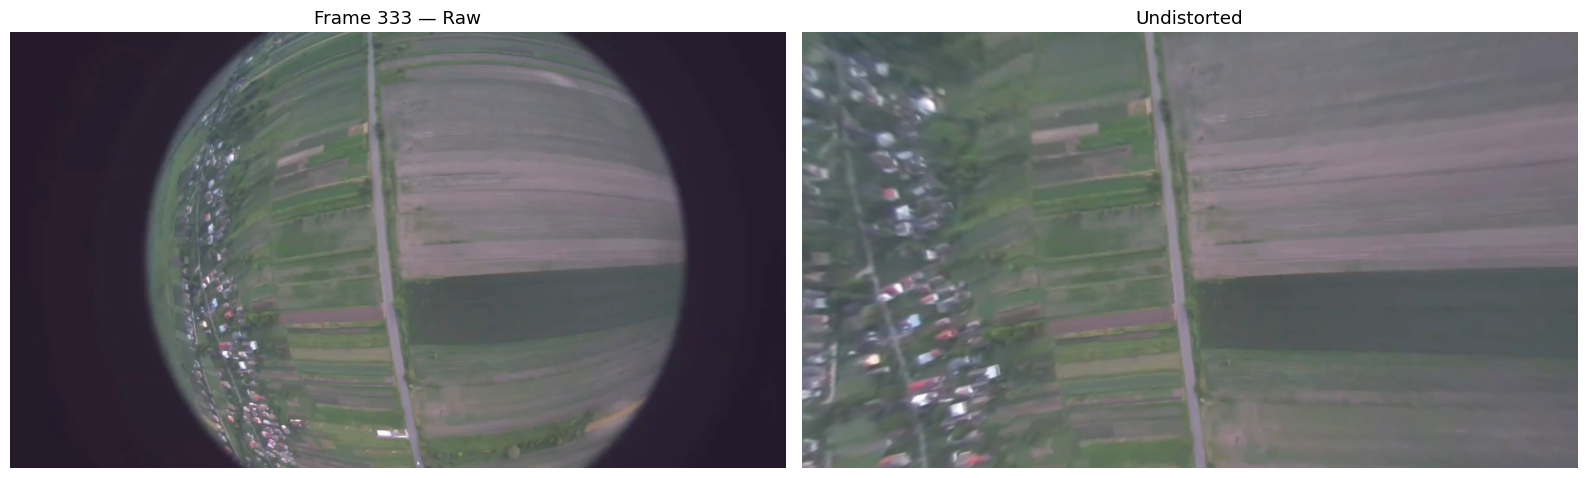

In [115]:
sample_frame_index = 333
raw_frame = read_frame(VIDEO_PATH, sample_frame_index)
undistorted_frame = undistort_with_maps(raw_frame, undistort_map1, undistort_map2)

print(f"Raw frame shape        : {raw_frame.shape}")
print(f"Undistorted frame shape: {undistorted_frame.shape}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(cv.cvtColor(raw_frame, cv.COLOR_BGR2RGB))
axes[0].set_title(f"Frame {sample_frame_index} — Raw")
axes[0].axis("off")

axes[1].imshow(cv.cvtColor(undistorted_frame, cv.COLOR_BGR2RGB))
axes[1].set_title("Undistorted")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 2. Feature Detection and Tracking

Use Shi–Tomasi corners (`cv.goodFeaturesToTrack`) for feature detection and Lucas–Kanade optical flow on the undistorted frames. You're encouraged to experiment with other feature detection algorithms (SIFT, ORB, etc)

## Helpers

In [ ]:
THRESHOLDS_ROI = [1, 0.1, 0.05, 0.01, 0.005, 0.001]
MIN_FEATURE_DISTANCE = 10 ## SOFIA CAN EXPERIMENT FOR BETTER VO PERFORMANCE
DEFAULT_LK_PARAMETERS = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

def auto_lower_threshold_roi(roi, start_x, start_y, exp_value_corners):
    """Lower the threshold ot shi-tomasi to some extend. If it is a bad flat region outputs None"""
    for threshold in THRESHOLDS_ROI:
        corners = cv.goodFeaturesToTrack(roi, exp_value_corners, threshold, MIN_FEATURE_DISTANCE)
        if corners is not None and len(corners) >= exp_value_corners:
            corners_ = []
            for corner in corners:

                corner[0][0] += start_x
                corner[0][1] += start_y
                corners_.append(corner)
            return corners_
    
    

In [ ]:
def good_features(
    gray: np.ndarray,
    max_corners: int = 3000,
    grid_rows: int = 8,
    grid_cols: int = 8,
) -> Optional[np.ndarray]:
    """
    Uniformly sample features  across the image by dividing it into a grid
    and extracting up to max_corners features distributed among cells.
    """

    corners = []
        

    batch_step_y, batch_step_x = gray.shape[0] // grid_rows, gray.shape[1] // grid_cols

    area_diff = (gray.shape[0] * gray.shape[1]) / (batch_step_y * batch_step_x)
    max_expected_corners = max_corners / area_diff

    for col in range(grid_cols):
        start_y = col * batch_step_y
        end_y = min(start_y + batch_step_y - 1, gray.shape[0]) ## guard

        for row in range(grid_rows):
            start_x = row * batch_step_x
            end_x = min(start_x + batch_step_x - 1, gray.shape[1])

            roi = gray[start_y:end_y, start_x:end_x]
            cur_corners = auto_lower_threshold_roi(roi, start_x, start_y, int(max_expected_corners))
            
            if cur_corners is None:
                continue
            corners += cur_corners

    return np.array(corners)
    
def compute_good_feature_tracks(
    gray1: np.ndarray,
    gray2: np.ndarray,
    prev_pts: Optional[np.ndarray] = None,
    max_corners: int = 3000,
    lk_params: Optional[dict] = None,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Run Lucas-Kanade tracking on Shi-Tomasi features between two grayscale frames.

    Returns:
        prev_pts: points on the first frame with shape (N, 1, 2) or None
        curr_pts: corresponding points on the second frame with shape (N, 1, 2) or None
        status_mask: boolean array marking which points were successfully tracked
    """
    lk_params = lk_params if lk_params is not None else DEFAULT_LK_PARAMETERS
    
    
    cur_pts = good_features(gray2, max_corners, 8, 8)

    if (prev_pts is None):
        prev_pts = good_features(gray1, max_corners, 8, 8)
    
    # print(f"{prev_pts.shape = }")
    # print(f"{cur_pts.shape = }")
    
    new_points, status, _ = cv.calcOpticalFlowPyrLK(gray1,
            gray2, prev_pts, cur_pts, **lk_params)
    
    status = status.ravel().astype(bool)
    
    return prev_pts, new_points, status

def track_good_features(
    img1_bgr: np.ndarray,
    img2_bgr: np.ndarray,
    max_corners: int = 3000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Shi-Tomasi + LK. Green = tracked correspondences, red dots = lost tracks in img1."""
    gray1 = cv.cvtColor(img1_bgr, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(img2_bgr, cv.COLOR_BGR2GRAY)

    prev_pts, curr_pts, status_all = compute_good_feature_tracks(
        gray1,
        gray2,
        prev_pts=None,
        max_corners=max_corners
    )

    if prev_pts is None or curr_pts is None or status_all is None:
        raise RuntimeError("Feature tracking failed")

    status_all = np.asarray(status_all, dtype=bool)
    pts1 = prev_pts.reshape(-1, 2)
    pts2 = curr_pts.reshape(-1, 2)

    good_prev = pts1[status_all]
    good_curr = pts2[status_all]
    lost_prev = pts1[~status_all]

    h1, w1 = img1_bgr.shape[:2]
    h2, w2 = img2_bgr.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    vis[:h1, :w1] = img1_bgr
    vis[:h2, w1:w1 + w2] = img2_bgr

    # draw tracked correspondences (green)
    for (x1, y1), (x2, y2) in zip(good_prev, good_curr):
        x1, y1, x2, y2 = map(lambda v: int(np.round(v).item()), (x1, y1, x2, y2))
        cv.line(vis, (x1, y1), (x2 + w1, y2), (0, 255, 0), 1, cv.LINE_AA)
        cv.circle(vis, (x1, y1), 3, (0, 255, 0), -1, cv.LINE_AA)
        cv.circle(vis, (x2 + w1, y2), 3, (0, 255, 0), -1, cv.LINE_AA)

    # draw lost points (red) on img1
    for (x1, y1) in lost_prev:
        x1, y1 = int(np.round(x1).item()), int(np.round(y1).item())
        cv.circle(vis, (x1, y1), 3, (0, 0, 255), -1, cv.LINE_AA)

    vis_rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)

    # Return tracked pairs only + status over all initial points
    return pts1, pts2, status_all, vis_rgb

## TESTING

In [118]:
sample_frame_index_0 = 333
raw_frame_0 = read_frame(VIDEO_PATH, sample_frame_index_0)
undistorted_frame_0 = undistort_with_maps(raw_frame_0, undistort_map1, undistort_map2)

sample_frame_index_1 = 335
raw_frame_1 = read_frame(VIDEO_PATH, sample_frame_index_1)
undistorted_frame_1 = undistort_with_maps(raw_frame_1, undistort_map1, undistort_map2)


test_gray_frame_0 = cv.cvtColor(undistorted_frame_0, cv.COLOR_BGR2GRAY)
test_gray_frame_1 = cv.cvtColor(undistorted_frame_1, cv.COLOR_BGR2GRAY)


f0 = good_features(test_gray_frame_0, 1500, 8, 8)
f1 = good_features(test_gray_frame_1, 1500, 8, 8)



outputs = compute_good_feature_tracks(test_gray_frame_0, test_gray_frame_1, f0, 1500)

prev_pts.shape = (1472, 1, 2)
cur_pts.shape = (1472, 1, 2)


prev_pts.shape = (128, 1, 2)
cur_pts.shape = (128, 1, 2)
Detected features frame 1: 128
Tracked points frame 2: 112


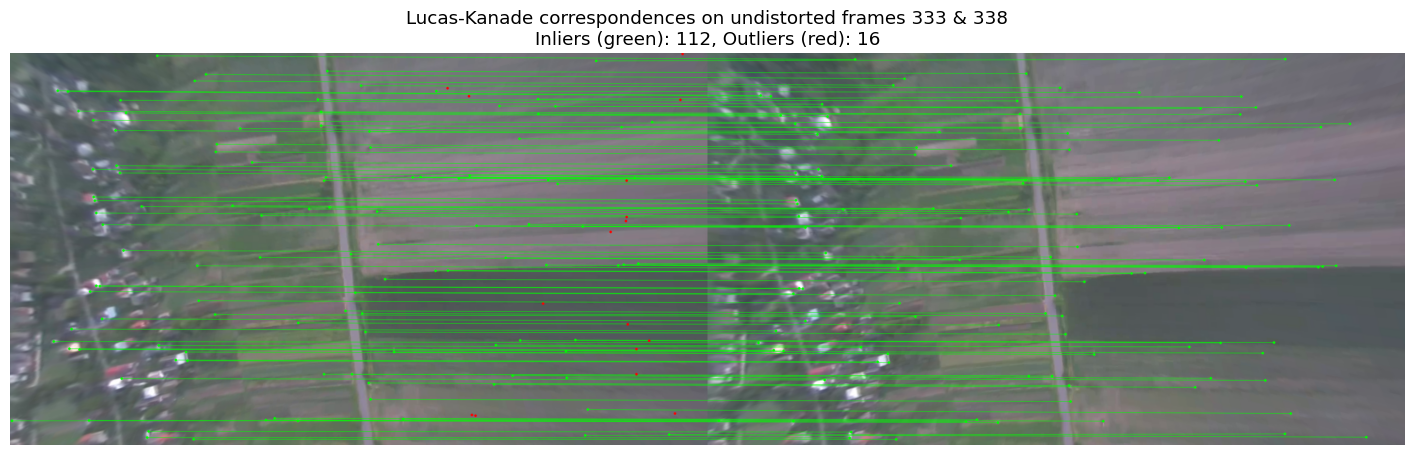

In [119]:
offset_frame = 5
raw_a, raw_b = read_frame_pair(VIDEO_PATH, sample_frame_index, offset_frame)
rect_a = undistort_with_maps(raw_a, undistort_map1, undistort_map2)
rect_b = undistort_with_maps(raw_b, undistort_map1, undistort_map2)

prev_pts, curr_pts, inlier_mask, vis_matches = track_good_features(
    rect_a,
    rect_b,
    max_corners=150,
)

num_tracked = len(prev_pts)
num_inliers = int(inlier_mask.sum())

print(f"Detected features frame 1: {num_tracked}")
print(f"Tracked points frame 2: {num_inliers}")

plt.figure(figsize=(18, 8))
plt.imshow(vis_matches)
plt.title(
    f"Lucas-Kanade correspondences on undistorted frames {sample_frame_index} & {sample_frame_index + offset_frame}\n"
    f"Inliers (green): {num_inliers}, Outliers (red): {num_tracked - num_inliers}"
)
plt.axis("off")
plt.show()

## 3. Homography-Based Trajectory (Fisheye)

Using only feature detections, track corners through the sequence, estimate inter-frame homographies, and pick the motion hypothesis that keeps pose as close as possible to nadir (homework assumption). The accumulated poses form a relative path (scale remains arbitrary).

In [120]:
from tqdm import tqdm


def choose_pose_candidate(
    Rs: List[np.ndarray],
    ts: List[np.ndarray],
    normals: List[np.ndarray]
) -> Optional[Tuple[np.ndarray, np.ndarray]]:
    """
    Select the pose (R, t) whose associated normal is closest to nadir ([0, 0, 1])
    and return it.

    Hint: Use cosine similarity to find the best match.
    """

    if normals is None:
        raise ValueError("Normals are not provided")

    expected_normal = np.array([0.0, 0.0, 1.0])
        
    pass


def recover_homography_trajectory(
    video_path: Path,
    map1: np.ndarray,
    map2: np.ndarray,
    K_rectified: np.ndarray,
    min_inliers: int = 60,
    min_points: int = 120,
    max_corners: int = 4000,
    output_video_path: Optional[Path] = None,
    draw_thickness: int = 1,
) -> TrajectoryResult:
    """
    Recover a trajectory from a video using homography-based pose estimation.

    TODO: Implement the homography-based trajectory recovery logic here
    
    Steps to implement:
    1. Undistort the current frame +
    2. Track features from previous frame to current frame
    3. Handle cases where tracking fails (reacquire features if below min_inliers threshold)
    4. Filter tracked points based on status
    5. Check if enough points remain (reacquire features if below min_points threshold)
    6. Compute homography using RANSAC
    7. Check if homography is valid and has enough inliers (min_inliers threshold)
    8. Decompose homography to extract rotation and translation
    9. Update the camera pose (current_R and current_pos)
    10. Store trajectory data (timestamps, positions, inliers, frame_indices)
    11. Write frame with overlay to output video if enabled
    """
    cap = cv.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open {video_path}")

    fps = cap.get(cv.CAP_PROP_FPS)
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    print(f"Video FPS: {fps:.2f}, total frames: {total_frames}")

    ret, prev_raw = cap.read()
    if not ret:
        cap.release()
        raise RuntimeError("Could not read first frame")
    video_writer = TrajectoryVideoWriter(output_video_path, fps, (w, h), draw_thickness)

    # TODO: Find the initial set of features

    timestamps: List[float] = []
    inliers: List[int] = []
    frame_indices: List[int] = []

    current_R = np.eye(3, dtype=float)
    current_pos = np.zeros(3, dtype=float)
    positions = [current_pos.copy()]

    processed = 0

    with tqdm(total=total_frames, desc="Recovering Homography Trajectory") as pbar:
        while True:
            ret, curr_raw = cap.read()
            if not ret:
                break
            video_writer.increment_frame()
            
            
            # Save the visualization of the current frame
            # video_writer.write_frame_with_overlay(...)
            
    print(f"Processed {processed} frames, recovered {len(frame_indices)} poses")
    if output_video_path is not None:
        print(f"Wrote overlay video: {output_video_path}")

    return TrajectoryResult(
        timestamps=timestamps,
        positions=np.vstack(positions),
        inliers=inliers,
        frame_indices=frame_indices,
    )


In [121]:
import pathlib
print("Starting homography-based trajectory recovery...")
traj_result = recover_homography_trajectory(
    VIDEO_PATH,
    undistort_map1,
    undistort_map2,
    NEW_K,
    min_inliers=60,
    max_corners=1000,
    min_points=300,
    output_video_path=Path("undistorted_features.mp4")
)

plot_trajectory(traj_result)


Starting homography-based trajectory recovery...
Video FPS: 19.85, total frames: 3561


NameError: name 'w' is not defined

In [ ]:
write_video_with_trajectory(
    "undistorted_features.mp4",
    traj_result,
    output_path="trajectory_overlay.mp4",
    stride=1,
)

In [ ]:
# analyze_trajectory is imported from pose_helpers
analyze_trajectory(traj_result, Path("flight/flight_trajectory_coordinates.csv"))